In [50]:
!pip install -q tensorflow_hub

In [51]:
!pip install -q tensorflow-text --no-dependencies

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from time import process_time

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from keras import backend as K

%matplotlib inline

**Import dataset & visualization**

In [53]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head(2)

,ID,Title,Domain
0,1,"What is good in a decision tree, a large or a ...",Techniques
1,2,Training data only contains single positive label,Techniques


In [4]:
test.head(2)

,ID,Title
0,3846,Spark Cheatsheet
1,3847,Review of Random forest code in Python


In [5]:
print('train shape:', train.shape, '; test shape:', test.shape)

train shape: (3845, 3) ; test shape: (1649, 2)


In [6]:
train['Domain'].unique()

array(['Techniques', 'Hackathons', 'Misc', 'Tools', 'Career', 'Resources',
       'Other'], dtype=object)

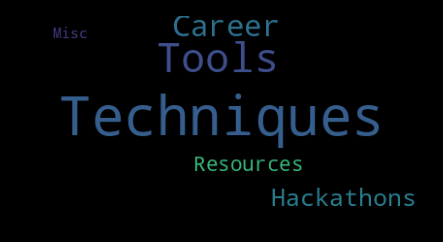

In [7]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(train['Domain'].tolist()))
plt.figure( figsize=(5,7), facecolor='k' )
plt.imshow( wordcloud )

In [8]:
train.isna().sum()

ID         0
Title     11
Domain     0
dtype: int64

In [54]:
train.dropna(axis=0, inplace=True)

In [55]:
train['Labels'] = train['Domain'].map({'Techniques': 0,
                                       'Hackathons': 1,
                                       'Misc': 2,
                                       'Tools': 3,
                                       'Career': 4,
                                       'Resources':5,
                                       'Other':6})

In [14]:
train.sample(5)

,ID,Title,Domain,Labels
614,615,"On performing division in jupyter notebook, it...",Tools,3
101,102,McKinsey Analytics Hackathon - Healthcare Anal...,Hackathons,1
2121,2122,Anyone read Introduction to Machine Learning w...,Resources,5
539,540,Guidance required. Please help,Resources,5
2141,2142,"Difference between AI , ML and DS?",Career,4


**Splitting**

In [56]:
num_classes = len(train['Domain'].value_counts())

In [57]:
y = tf.keras.utils.to_categorical( train['Labels'].values, num_classes=num_classes )
x_train, x_test, y_train, y_test = train_test_split( train['Title'], y, test_size=0.25 )

In [58]:
len(x_train), len(x_test), len(y_train), len(y_test)

(2875, 959, 2875, 959)

In [59]:
for i in range(1, 6):
  print(x_train[i-1:i], y_train[i-1:i])
  print('--------------------------')

3473    Which file formats can we import into a data t...
Name: Title, dtype: object [[0. 0. 0. 1. 0. 0. 0.]]
--------------------------
1792    Complete Guide to Parameter Tuning in Gradient...
Name: Title, dtype: object [[1. 0. 0. 0. 0. 0. 0.]]
--------------------------
3630    What is the function of the formula used in ld...
Name: Title, dtype: object [[0. 0. 0. 1. 0. 0. 0.]]
--------------------------
2367    Is Analytics making an impact in today's world?
Name: Title, dtype: object [[0. 0. 0. 0. 0. 0. 1.]]
--------------------------
260    How to create stack of bar plot in python?
Name: Title, dtype: object [[0. 0. 0. 1. 0. 0. 0.]]
--------------------------


BERT

In [60]:
preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

In [61]:
def get_embeddings(sentences):
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']

get_embeddings(['Hi', 'Bye'])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[ 0.50227994,  0.00185778,  0.60762304, ...,  0.3556815 ,
        -0.27669203,  0.5098554 ],
       [ 0.34677243, -0.1910456 ,  0.6675579 , ...,  0.4774239 ,
        -0.558291  , -0.10359976]], dtype=float32)>

**Model**

In [62]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name='dropout')(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name='output')(x)

model = tf.keras.Model(i, x)

**Metrics**

In [63]:
def balanced_recall(y_true, y_pred):
    recall_by_class = 0
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    precision_by_class = 0
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [64]:
x_train = np.array([np.array(val) for val in x_train])

**Let's go**

In [ ]:
start = process_time()
n_epochs = 20

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
           balanced_recall,
           balanced_precision,
           balanced_f1_score]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = METRICS)

model_fit = model.fit(x_train,
                      y_train,
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

end = process_time()
print(end-start)

**Predictions**

In [24]:
sentences = ["How to deal with constant variables?",
             "R and SQL Server Connection",
             "Reading a dat file in R"]

def predict_class(sentences):
  return [np.argmax(pred) for pred in model.predict(sentences)]

predict_class(sentences)

In [24]:
from sklearn.metrics import classification_report

y_pred = predict_class(test["Title"])

In [ ]:
baseline_pred = predict_class(x_test)

**Evaluation of model**

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_recall_fscore_support
def calculate(y_true, y_pred):

  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall" : model_recall,
                   "f1": model_f1}
  return model_results

In [ ]:
baseline_results = calculate( y_true=np.argmax(y_test, axis=1), y_pred=baseline_pred )
baseline_results